In [1]:
import tensorflow as tf

# Check if GPU is available
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

# Configure TensorFlow to use the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')


if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

GPU found
1 Physical GPUs, 1 Logical GPUs


In [2]:
#print len of random 50 classes and images in each class
import os
output_dir = r"C:\Users\Administrator\Desktop\EfficientNet\Augmented_20_Classes"

selected_classes = [folder for folder in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, folder))]
for class_name in selected_classes:
    class_dir = os.path.join(output_dir, class_name)
    num_images = len([file for file in os.listdir(class_dir)])
    print(f"{class_name}: {num_images} images")

106: 1476 images
11: 1476 images
112: 1476 images
119: 1476 images
120: 1476 images
144: 1476 images
153: 1476 images
157: 1476 images
165: 1476 images
167: 1476 images
178: 1476 images
222: 1476 images
223: 1476 images
226: 1476 images
240: 1476 images
260: 1476 images
273: 1476 images
278: 1476 images
29: 1476 images
308: 1476 images


In [3]:
import cv2
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from transformers import AutoImageProcessor, TFViTModel
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense,Flatten


# Load the dataset directory path
# data_dir = "M:/Datasets/aloi_ill/png"  # Update this to your dataset path
data_dir = r"M:\SIFT\small_data"  # Update this to your dataset path
data_dir = r"C:\Users\Administrator\Desktop\EfficientNet\SIFT\small_data"  # Update this to your dataset path
data_dir = r"C:\Users\Administrator\Desktop\EfficientNet\Random_20_Classes"
data_dir = r"C:\Users\Administrator\Desktop\EfficientNet\Augmented_20_Classes"

image_paths = []
labels = []

# Load images and assign labels based on folder names
for label in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, label)
    if os.path.isdir(class_dir):
        for file in os.listdir(class_dir):
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, file))
                labels.append(int(label))  # Convert folder name to integer label



print(image_paths)
print(len(labels))

print(len(image_paths))






c:\Users\Administrator\anaconda3\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_20_Classes\\106\\aug_0.jpg', 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_20_Classes\\106\\aug_1.jpg', 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_20_Classes\\106\\aug_10.jpg', 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_20_Classes\\106\\aug_100.jpg', 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_20_Classes\\106\\aug_1000.jpg', 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_20_Classes\\106\\aug_1001.jpg', 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_20_Classes\\106\\aug_1002.jpg', 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_20_Classes\\106\\aug_1003.jpg', 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_20_Classes\\106\\aug_1004.jpg', 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_20_Classes\\106\\aug_1005.jpg', 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_20_Classes\\106\\aug_1006.jp

In [7]:
print(len(image_paths))
print(len(labels))
print(labels[5000:5010])

29520
29520
[119, 119, 119, 119, 119, 119, 119, 119, 119, 119]


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling1D

# Load ViT Model
base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
base_model.trainable = False  # Freeze pretrained weights

inputs = Input(shape=(3, 224, 224), name='pixel_values', dtype='float32')

vit_output = base_model(inputs).last_hidden_state
pooled_output = GlobalAveragePooling1D()(vit_output)  # Reduce sequence dimension

model = Model(inputs=inputs, outputs=pooled_output)

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [8]:

img1= cv2.imread(image_paths[0])
img1 = cv2.resize(img1, (224, 224))  # Resize to EfficientNet input size
img1 = np.transpose(img1, (2, 0, 1))  # Transpose the image to shape (3, 224, 224)
img1 = preprocess_input(img1)  # Preprocess the image
img1 = np.expand_dims(img1, axis=0)  # Add batch dimension



In [9]:
feature = model(img1)  # Extract features
feature = Flatten()(feature)
print(feature.shape)

(1, 151296)


In [13]:
def extract_features(image_paths, batch_size=64, output_dir="features"):
    import shutil
    import os
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    
    os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = []
        
        for image_path in batch_paths:
            print(f"Processing: {image_path}")
            img = cv2.imread(image_path)
            img = cv2.resize(img, (224, 224))  # Resize to ViT input size
            img = np.transpose(img, (2, 0, 1))
            img = preprocess_input(img)  # Preprocess for ViT
            batch_images.append(img)

        
        batch_images = np.array(batch_images)  # Create a batch
        batch_features = model.predict(batch_images, batch_size=batch_size)  # Extract features
        
        # Save batch features to disk
        batch_file = os.path.join(output_dir, f"batch_{i//batch_size}.npy")
        np.save(batch_file, batch_features)
        print(f"Saved features for batch {i//batch_size} to {batch_file}")

    print(f"Features saved to directory: {output_dir}")

# # Extract features for all images
extract_features(image_paths,output_dir="data_features")

Processing: C:\Users\Administrator\Desktop\EfficientNet\Augmented_20_Classes\106\aug_0.jpg
Processing: C:\Users\Administrator\Desktop\EfficientNet\Augmented_20_Classes\106\aug_1.jpg
Processing: C:\Users\Administrator\Desktop\EfficientNet\Augmented_20_Classes\106\aug_10.jpg
Processing: C:\Users\Administrator\Desktop\EfficientNet\Augmented_20_Classes\106\aug_100.jpg
Processing: C:\Users\Administrator\Desktop\EfficientNet\Augmented_20_Classes\106\aug_1000.jpg
Processing: C:\Users\Administrator\Desktop\EfficientNet\Augmented_20_Classes\106\aug_1001.jpg
Processing: C:\Users\Administrator\Desktop\EfficientNet\Augmented_20_Classes\106\aug_1002.jpg
Processing: C:\Users\Administrator\Desktop\EfficientNet\Augmented_20_Classes\106\aug_1003.jpg
Processing: C:\Users\Administrator\Desktop\EfficientNet\Augmented_20_Classes\106\aug_1004.jpg
Processing: C:\Users\Administrator\Desktop\EfficientNet\Augmented_20_Classes\106\aug_1005.jpg
Processing: C:\Users\Administrator\Desktop\EfficientNet\Augmented_20_

In [14]:
import shutil

# Use features from the saved files
labels = np.array(labels)

def load_features(feature_dir):
    features = []
    for file in os.listdir(feature_dir):
        print(file)
        batch_file = os.path.join(feature_dir, file)
        batch_features = np.load(batch_file)
        features.append(batch_features)
    return np.vstack(features)

# Load features from disk
feature_dir = "data_features"

# Clear the directory if it exists

# Create the directory again
os.makedirs(feature_dir, exist_ok=True)

combined_features = load_features(feature_dir)


batch_0.npy
batch_1.npy
batch_10.npy
batch_100.npy
batch_101.npy
batch_102.npy
batch_103.npy
batch_104.npy
batch_105.npy
batch_106.npy
batch_107.npy
batch_108.npy
batch_109.npy
batch_11.npy
batch_110.npy
batch_111.npy
batch_112.npy
batch_113.npy
batch_114.npy
batch_115.npy
batch_116.npy
batch_117.npy
batch_118.npy
batch_119.npy
batch_12.npy
batch_120.npy
batch_121.npy
batch_122.npy
batch_123.npy
batch_124.npy
batch_125.npy
batch_126.npy
batch_127.npy
batch_128.npy
batch_129.npy
batch_13.npy
batch_130.npy
batch_131.npy
batch_132.npy
batch_133.npy
batch_134.npy
batch_135.npy
batch_136.npy
batch_137.npy
batch_138.npy
batch_139.npy
batch_14.npy
batch_140.npy
batch_141.npy
batch_142.npy
batch_143.npy
batch_144.npy
batch_145.npy
batch_146.npy
batch_147.npy
batch_148.npy
batch_149.npy
batch_15.npy
batch_150.npy
batch_151.npy
batch_152.npy
batch_153.npy
batch_154.npy
batch_155.npy
batch_156.npy
batch_157.npy
batch_158.npy
batch_159.npy
batch_16.npy
batch_160.npy
batch_161.npy
batch_162.npy
bat

In [15]:
#print the shape of the features
print(combined_features.shape)

(29520, 768)


In [16]:
#flatten the features
combined_features = combined_features.reshape(combined_features.shape[0], -1)

In [17]:
combined_features = np.squeeze(combined_features)

In [18]:
combined_features.shape, labels.shape

((29520, 768), (29520,))

In [19]:
# Step 3: Train and test classifier
# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(combined_features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


In [20]:
print(X_train[0])
print(y_train[0])

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

[ 4.66622189e-02 -2.34632477e-01  1.39932781e-01 -4.44354489e-02
 -1.56999379e-02 -1.55583560e-01 -2.18856353e-02 -6.87451884e-02
  1.35693267e-01  1.13598723e-02 -8.59672427e-02 -1.28683344e-01
  1.87740579e-01  1.02910455e-02 -4.24166657e-02  6.17799386e-02
 -1.32166129e-02 -4.38063778e-02 -1.55498972e-02 -9.71683338e-02
 -7.03115687e-02  1.13747776e-01  5.03495857e-02 -1.48009760e-02
 -1.86638571e-02  3.93878110e-02 -1.17424056e-01 -2.85358503e-02
 -1.97190583e-01  1.69302239e-05  6.89570010e-02 -2.91279070e-02
 -7.32303634e-02  4.80620377e-02  6.27324805e-02  4.05078579e-04
 -1.08980201e-02 -6.27061278e-02 -5.89627912e-03  7.17187896e-02
 -5.57650588e-02  1.70171842e-01 -8.60009864e-02  2.70747393e-01
  4.59218286e-02  1.65998414e-01 -3.62132229e-02  3.68904471e-02
 -1.39784306e-01  2.72466056e-02  8.44946653e-02 -1.39984310e-01
 -3.16213537e-03  3.47074457e-02  3.39177661e-02 -5.06091081e-02
  4.99201491e-02  5.52747697e-02 -1.88683152e-01  1.42872846e-02
 -2.44002435e-02 -7.27199

In [21]:
from sklearn.decomposition import PCA

# Perform PCA to reduce dimensionality
pca = PCA(n_components=1000)  # You can adjust the number of components as needed
reduced_features = pca.fit_transform(combined_features)

print("Original shape:", combined_features.shape)
print("Reduced shape:", reduced_features.shape)

Original shape: (29520, 151296)
Reduced shape: (29520, 1000)


In [43]:
import numpy as np

# Count frequency of numbers in y_train
unique_train, counts_train = np.unique(y_train, return_counts=True)
frequency_train = dict(zip(unique_train, counts_train))

# Count frequency of numbers in y_test
unique_test, counts_test = np.unique(y_test, return_counts=True)
frequency_test = dict(zip(unique_test, counts_test))

print("Frequency in y_train:", frequency_train)
print("Frequency in y_test:", frequency_test)

Frequency in y_train: {29: 18, 153: 12, 222: 15, 223: 17, 240: 11, 273: 19, 386: 20, 450: 17, 489: 18, 501: 18, 571: 20, 650: 20, 674: 16, 680: 16, 684: 21, 737: 19, 859: 15, 890: 15, 899: 16, 996: 13}
Frequency in y_test: {29: 3, 153: 8, 222: 6, 223: 4, 240: 8, 273: 1, 386: 2, 450: 1, 489: 1, 501: 3, 571: 3, 650: 2, 674: 4, 680: 7, 684: 2, 737: 2, 859: 4, 890: 5, 899: 3, 996: 3}


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Reshape the data to fit LSTM input requirements
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Convert labels to categorical
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)


In [22]:

# Build the model
model_lstm = Sequential([
    LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(y_train_cat.shape[1], activation='softmax')
])
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [23]:

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)


In [24]:
# Train the model with early stopping
history = model_lstm.fit(X_train_lstm, y_train_cat, epochs=600, batch_size=64, validation_data=(X_val_lstm, y_val_cat), verbose=1)





Epoch 1/600
323/323 [==============================] - 2s 4ms/step - loss: 3.0659 - accuracy: 0.2328 - val_loss: 2.3517 - val_accuracy: 0.4079
Epoch 2/600
323/323 [==============================] - 1s 3ms/step - loss: 1.8686 - accuracy: 0.5118 - val_loss: 1.5249 - val_accuracy: 0.5829
Epoch 3/600
323/323 [==============================] - 1s 3ms/step - loss: 1.3265 - accuracy: 0.6139 - val_loss: 1.2147 - val_accuracy: 0.6102
Epoch 4/600
323/323 [==============================] - 1s 3ms/step - loss: 1.1071 - accuracy: 0.6317 - val_loss: 1.0667 - val_accuracy: 0.6186
Epoch 5/600
323/323 [==============================] - 1s 3ms/step - loss: 0.9919 - accuracy: 0.6364 - val_loss: 0.9854 - val_accuracy: 0.6229
Epoch 6/600
323/323 [==============================] - 1s 3ms/step - loss: 0.9247 - accuracy: 0.6397 - val_loss: 0.9362 - val_accuracy: 0.6260
Epoch 7/600
323/323 [==============================] - 1s 3ms/step - loss: 0.8809 - accuracy: 0.6428 - val_loss: 0.8972 - val_accuracy: 0.6278

In [25]:
history.history.keys()
print(history.history.keys())
print(history.history['accuracy'])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
[0.23277197778224945, 0.5118079781532288, 0.6138695478439331, 0.6316782832145691, 0.6364208459854126, 0.6397115588188171, 0.642808735370636, 0.6489546895027161, 0.6493902206420898, 0.6506000757217407, 0.6513743996620178, 0.6521002650260925, 0.6518099308013916, 0.6541327834129333, 0.654423177242279, 0.654423177242279, 0.6564556956291199, 0.6552942395210266, 0.6596496105194092, 0.6589721441268921, 0.6566492319107056, 0.6597464084625244, 0.662746787071228, 0.6613917946815491, 0.6615853905677795, 0.6632307171821594, 0.6641502380371094, 0.6645857691764832, 0.6662794947624207, 0.6659407615661621, 0.6651664972305298, 0.6645373702049255, 0.6683604121208191, 0.6670054197311401, 0.6710704565048218, 0.6705865263938904, 0.6708285212516785, 0.6694734692573547, 0.6707801222801208, 0.6733449697494507, 0.6733933687210083, 0.67653888463974, 0.6761033535003662, 0.6762001514434814, 0.6778939366340637, 0.675474226474762, 0.6781842708587646, 0.676

In [26]:
# Assuming you want to print the test accuracy

# Evaluate the model on the test set
loss, accuracy = model_lstm.evaluate(X_test_lstm, y_test_cat, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

Test Loss: 1.5876
Test Accuracy: 0.5752


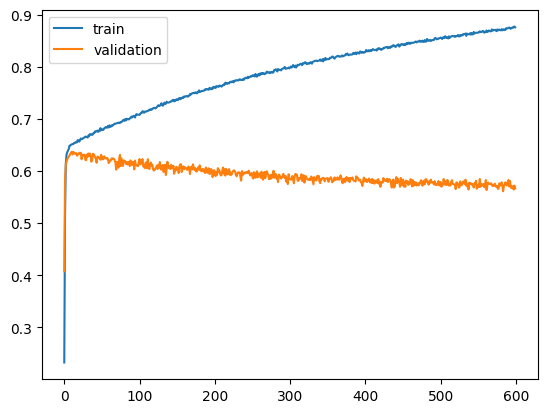

In [27]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()